In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import numpy as np
import torch.optim as optim
from tqdm import tqdm

from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Working with {device}")

Working with cpu


In [2]:
class FCV(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32, 32), activation_fc = nn.ReLU()):
        super(FCV, self).__init__()
        self.activation_fc = activation_fc
        self.layers = [(nn.Linear(input_dim, hidden_dims[0]))]

        for i in range(len(hidden_dims) - 1):
            self.layers.append(self.activation_fc)
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        self.layers.append(self.activation_fc)
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.layers = nn.Sequential(*self.layers)
    
    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).to(device)

        return self.layers(x)

class FCDAP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32, 32), init_std=1, activation_fc = nn.ReLU()):
        super(FCDAP, self).__init__()
        self.activation_fc = activation_fc
        self.layers = [(nn.Linear(input_dim, hidden_dims[0]))]

        for i in range(len(hidden_dims) - 1):
            self.layers.append(self.activation_fc)
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        self.layers.append(self.activation_fc)
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).to(device)

        return self.layers(x)

    def full_pass(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logpa = dist.log_prob(action)
        entropy = dist.entropy()
        is_exploratory = action != np.argmax(logits.detach().numpy())

        return action.item(), is_exploratory.item(), logpa, entropy

    def select_action(self, state):
        logits = self.forward(state).detach()
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample().detach().numpy()
        return action

    def select_greedy(self, state):
        logits = self.forward(state).detach()
        return np.argmax(logits.to('cpu').numpy())


In [12]:
class VPG:
    def __init__(self, env, gamma, hidden_dims, policy_optimizer, value_optimizer,beta, lr = (1e-4, 1e-4), clips = (1, 1)):
        self.env = env
        self.gamma = gamma
        self.policy_model = FCDAP(env.observation_space.shape[0], env.action_space.n, hidden_dims[0]).to(device)
        self.value_model = FCV(env.observation_space.shape[0], env.action_space.n, hidden_dims[1]).to(device)
        env.reset()
        self.entropy_loss_weight = beta

        self.policy_optimizer = policy_optimizer(self.policy_model.parameters(), lr[0])
        self.value_optimizer = value_optimizer(self.value_model.parameters(), lr[1])
        
        self.policy_model_max_grad_norm = clips[0]
        self.value_model_max_grad_norm = clips[1]
        self.returns = []
        

    def optimize_model(self):
        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = torch.Tensor([np.sum(discounts[:T-t]*self.rewards[t:]) for t in range(T)]).to(device)
        self.rewards = torch.Tensor(self.rewards).to(device)
        self.logpas = torch.stack(self.logpas).to(device)
        self.values = torch.stack(self.values).to(device)
        self.entropies = torch.stack(self.entropies).to(device)
        discounts = torch.Tensor(discounts).to(device)
        
        value_error = returns - self.values
        value_loss = value_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.value_model.parameters(),self.value_model_max_grad_norm)
        self.value_optimizer.step()

        policy_loss = -(discounts*value_error.detach()*self.logpas).mean()
        entropy_loss = -self.entropies.mean()
        loss = policy_loss + self.entropy_loss_weight*entropy_loss

        self.policy_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(),self.policy_model_max_grad_norm)
        self.policy_optimizer.step()

    def interactive_step(self, state):
        action, _, logpa, entropy = self.policy_model.full_pass(state)
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        value = self.value_model(state)[action]
        self.values.append(value)
        self.rewards.append(reward)
        self.logpas.append(logpa)
        self.entropies.append(entropy)
        return new_state, terminated or truncated

    def train(self, num_episodes, step, evals, thresh):
        
        for i in range(1, num_episodes + 1):
            self.rewards, self.logpas, self.entropies, self.values = [], [], [], []
            terminated = False
            state = self.env.reset()[0]

            while(not terminated):
                state, terminated = self.interactive_step(state)

            self.optimize_model()

            if(i%step == 0):
                if (self.evaluate(evals) > thresh):
                    torch.save(self.policy_model.state_dict(), f'./optimal_weights.pth')
                    return

    def evaluate(self, evals):
        for _ in range(evals):
            state = self.env.reset()[0]
            terminated = False
            return_val = 0
            while(not terminated):
                # img = self.env.render()
                # cv2.imshow("Environment", img)
                # cv2.waitKey(1)
                action = self.policy_model.select_greedy(state)
                state, reward, terminate, truncated, _ = self.env.step(action)
                terminated = truncated or terminate
                return_val += reward
            self.returns.append(return_val)

        # cv2.destroyAllWindows()
        plt.plot(range(len(self.returns)), self.returns)
        plt.show()
        last_mean = np.mean(self.returns[-evals:])
        print(f"Mean return value of last {evals} evaluations = {last_mean}")
        return last_mean


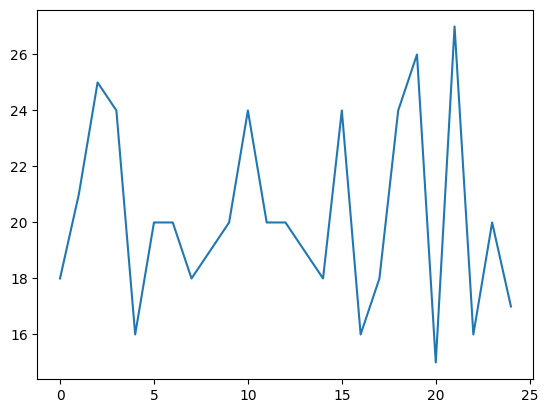

Mean return value of last 25 evaluations = 20.2


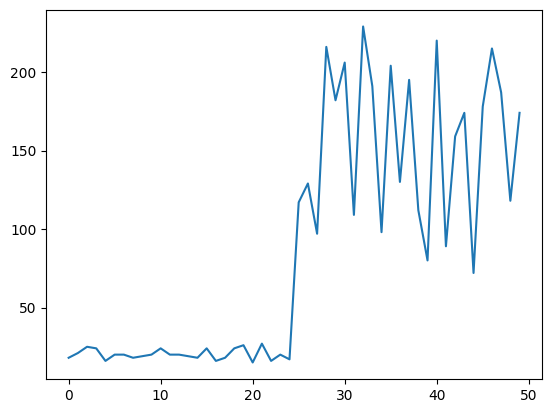

Mean return value of last 25 evaluations = 155.24


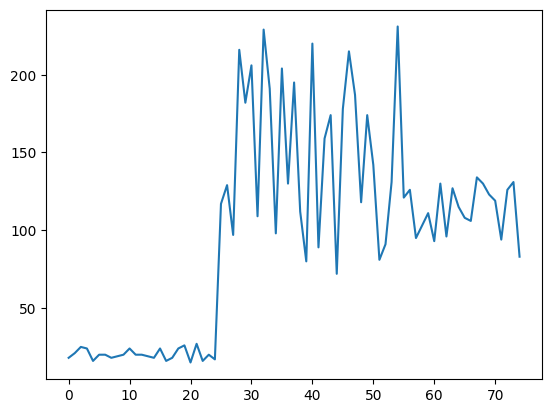

Mean return value of last 25 evaluations = 117.88


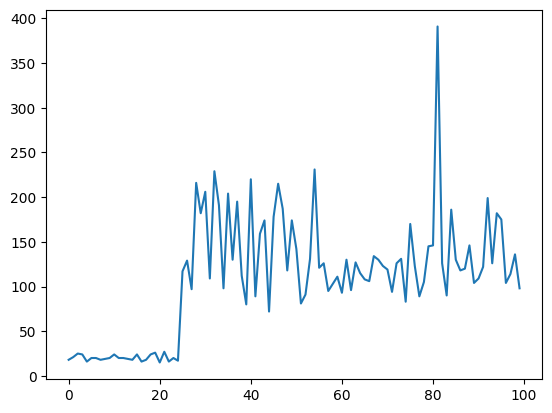

Mean return value of last 25 evaluations = 142.16


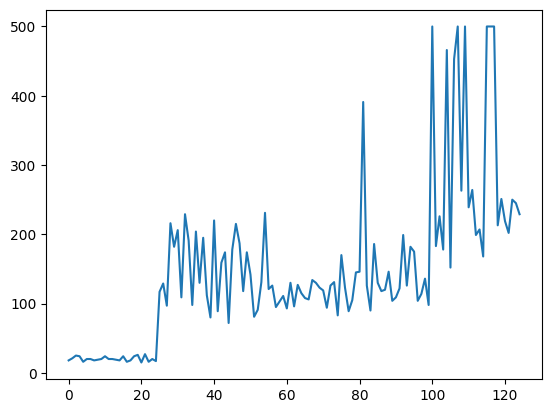

Mean return value of last 25 evaluations = 304.28


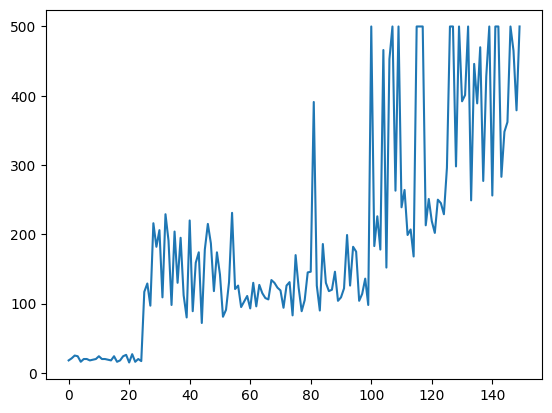

Mean return value of last 25 evaluations = 409.56


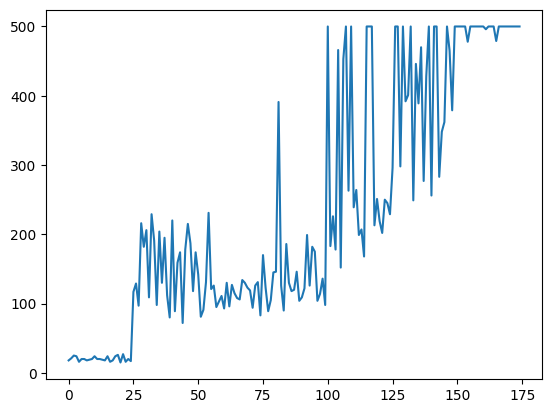

Mean return value of last 25 evaluations = 498.12


In [21]:
ENV = 'CartPole-v1'

GAMMA = 0.96
HIDDEN_DIMS = ((128, 64), (256, 128))
BETA = 0.01
LR = (7e-4, 1e-3)
TOTAL = 800
STEP = 50
EVALS = 25
THRESH = 450
CLIPS = (5, 5)

env = gym.make(ENV)

agent = VPG(env, GAMMA, HIDDEN_DIMS, optim.Adam, optim.Adam, BETA ,LR, CLIPS)
agent.train(TOTAL, STEP, EVALS, THRESH)

env.close()

In [ ]:
env_show = gym.make(ENV, render_mode = 'human')
terminated = False
state = env_show.reset()[0]

while not terminated:
    action = agent.policy_model.select_greedy(state)
    state, _, terminate, truncated, _ = env_show.step(action)
    terminated = terminate or truncated

env_show.close()